In [1]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.cross_validation import StratifiedKFold
import models
import utils
import xgboost as xgb
from keras.preprocessing.image import ImageDataGenerator
import glob
from scipy import misc
from skimage import transform
from matplotlib import pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled)


In [2]:
models = reload(models)

In [70]:


#get data
X, y = utils.get_pics("./train/*[0-9]_*[0-9].tif", True)

#define CV
labels = np.zeros(y.shape[0])
for i in range(len(labels)):
    if np.sum(y[i, 0, :, :]) > 0:
        labels[i] = 1


(2323, 1, 96, 128)


In [74]:
labels = np.expand_dims(labels, 1)

In [3]:
X = np.load('/mnt/weights/X.npy')
y = np.load('/mnt/weights/y.npy')
labels = np.load('/mnt/weights/labels.npy')

In [4]:
def trans(im1, im2):
    rands = np.random.rand(4) - .5

    tform = transform.AffineTransform(shear= rands[0] / 4., rotation= rands[1] / 5.,
                                        translation = (rands[2]*20., rands[3]*15.))
    im1 = transform.warp(im1, tform)
    im2 = transform.warp(im2, tform)

    return im1, im2

In [5]:
def generator(X, y):
    
    while 1:
        idx = np.random.choice(range(X.shape[0]), 32)
        X_batch = X[idx, :, :, :]
        y_batch = y[idx, :, :, :]

        for i in range(32):
            X_batch[i, 0, :, :], y_batch[i, 0, :, :] = trans(X_batch[i, 0, :, :], y_batch[i, 0, :, :])
        
        yield X_batch, y_batch

In [7]:
train_gen = generator(X, y)

model = None # Clearing the NN.
model = models.new_u_net_model()

Checkpoint = ModelCheckpoint('unet_full_weights.h5')
model.fit_generator(train_gen, 5600, 30,
                  callbacks = [Checkpoint])

#get data
X, y = utils.get_pics("./train/*[0-9]_*[0-9].tif", True)

#define CV
labels = np.zeros(y.shape[0])
for i in range(len(labels)):
    if np.sum(y[i, 0, :, :]) > 0:
        labels[i] = 1
labels = np.expand_dims(labels, 1)

train_gen = generator(X, y)

model = None # Clearing the NN.
model = models.new_u_net_model()
    
Checkpoint = ModelCheckpoint('unet_positive_full_weights.h5')
model.fit_generator(train_gen, 2500, 30,
                  callbacks = [Checkpoint])

Epoch 1/30
5600/5600 [==============================] - 370s - loss: -0.4024 - dice_coef: 0.4024   
Epoch 2/30
5600/5600 [==============================] - 369s - loss: -0.6019 - dice_coef: 0.6019   
Epoch 3/30
5600/5600 [==============================] - 369s - loss: -0.6220 - dice_coef: 0.6220   
Epoch 4/30
5600/5600 [==============================] - 369s - loss: -0.6319 - dice_coef: 0.6319   
Epoch 5/30
5600/5600 [==============================] - 369s - loss: -0.6364 - dice_coef: 0.6364   
Epoch 6/30
5600/5600 [==============================] - 369s - loss: -0.6564 - dice_coef: 0.6564   
Epoch 7/30
5600/5600 [==============================] - 369s - loss: -0.6578 - dice_coef: 0.6578   
Epoch 8/30
5600/5600 [==============================] - 369s - loss: -0.6511 - dice_coef: 0.6511   
Epoch 9/30
5600/5600 [==============================] - 369s - loss: -0.6662 - dice_coef: 0.6662   
Epoch 10/30
5600/5600 [==============================] - 369s - loss: -0.6607 - dice_coef: 0.6607   

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1464: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


In [75]:
n_folds = 2

skf = StratifiedKFold(labels[:,0], n_folds=n_folds, shuffle=True)

ES = EarlyStopping(monitor = 'val_loss', patience = 2, mode = 'min')

oos_class_preds = np.zeros(y.shape)
4
#train with Cross validation
for i, (train, test) in enumerate(skf):
    print "Running Fold", i+1, "/", n_folds

    model = None # Clearing the NN.
    model = models.new_u_net_model()

    train_datagen = ImageDataGenerator()
    train_generator = train_datagen.flow(X[train, :, :, :],y[train, :, :, :], shuffle=True, batch_size=32)
    
    
    train_gen = generator(X[train, :, :, :], y[train, :, :, :])
    
    Checkpoint = ModelCheckpoint('unet_fold_' + str(i) + '_weights.h5', save_best_only=True)
    model.fit_generator(train_gen, 2800, 30,
                      callbacks = [Checkpoint],
                      validation_data = (X[test, :, :, :], y[test, :, :, :]))
    
#     model = None # Clearing the NN.
#     model = models.u_net_class(u_weights = 'unet_fold_' + str(i) + '_weights.h5')
    
#     Checkpoint = ModelCheckpoint('class_fold_' + str(i) + '_weights.h5', save_best_only=True)
#     model.fit_generator(generator(X[train, :, :, :], labels[train,:]), 3700, 5,
#                       callbacks = [Checkpoint],
#                       validation_data = (X[test, :, :, :], labels[test,:]),)
#                        #class_weight = {0:.41, 1:.59})


    model = models.new_u_net_model('unet_fold_' + str(i) + '_weights.h5')
    oos_class_preds[test, :,:,:] = model.predict(X[test, :, :, :])

Running Fold 1 / 2
Epoch 1/30
2816/2800 [==============================] - 205s - loss: -0.5900 - dice_coef: 0.5900 - val_loss: -0.7723 - val_dice_coef: 0.7723
Epoch 2/30
2816/2800 [==============================] - 205s - loss: -0.7905 - dice_coef: 0.7905 - val_loss: -0.7930 - val_dice_coef: 0.7930
Epoch 3/30
2816/2800 [==============================] - 205s - loss: -0.8111 - dice_coef: 0.8111 - val_loss: -0.8003 - val_dice_coef: 0.8003
Epoch 4/30
2816/2800 [==============================] - 205s - loss: -0.8244 - dice_coef: 0.8244 - val_loss: -0.7793 - val_dice_coef: 0.7793
Epoch 5/30
2816/2800 [==============================] - 205s - loss: -0.8325 - dice_coef: 0.8325 - val_loss: -0.7944 - val_dice_coef: 0.7944
Epoch 6/30
2816/2800 [==============================] - 206s - loss: -0.8417 - dice_coef: 0.8417 - val_loss: -0.8037 - val_dice_coef: 0.8037
Epoch 7/30
2816/2800 [==============================] - 205s - loss: -0.8446 - dice_coef: 0.8446 - val_loss: -0.8023 - val_dice_coef: 0

KeyboardInterrupt: 

In [8]:
#get data
# X, y = utils.get_pics("./train/*[0-9]_*[0-9].tif", True)

# #define CV
# labels = np.zeros(y.shape[0])
# for i in range(len(labels)):
#     if np.sum(y[i, 0, :, :]) > 0:
#         labels[i] = 1

(2323, 1, 96, 128)


In [9]:
n_folds = 3

skf = StratifiedKFold(labels, n_folds=n_folds, shuffle=True)

ES = EarlyStopping(monitor = 'val_loss', patience = 2, mode = 'min')

oos_preds = np.zeros(y.shape)

#train with Cross validation
for i, (train, test) in enumerate(skf):
    print "Running Fold", i+1, "/", n_folds

    model = None # Clearing the NN.
    model = models.u_net_model()

    train_datagen = ImageDataGenerator()
    train_generator = train_datagen.flow(X[train, :, :, :],y[train, :, :, :], shuffle=True, batch_size=32)
    
    Checkpoint = ModelCheckpoint('unet_fold_' + str(i) + '_weights.h5', save_best_only=True)
    model.fit_generator(train_generator, 2000, 10,
                      callbacks = [Checkpoint],
                      validation_data = (X[test, :, :, :], y[test, :, :, :]))
    
    model = None # Clearing the NN.
    model = models.double_input_model(u_weights = 'unet_fold_' + str(i) + '_weights.h5')
    
    Checkpoint = ModelCheckpoint('all_pos_fold_' + str(i) + '_weights.h5', save_best_only=True)
    model.fit_generator(train_generator, 2000, 5,
                      callbacks = [Checkpoint],
                      validation_data = (X[test, :, :, :], y[test, :, :, :]))


    model = models.double_input_model('double_fold_' + str(i) + '_weights.h5')
    oos_preds[test, :, :, :] = model.predict(X[test, :, :, :])

Running Fold 1 / 3


KeyboardInterrupt: 

In [9]:
model = models.new_u_net_model('unet_fold_0_weights.h5')
oos_preds = model.predict(X)

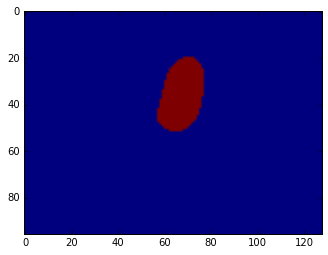

0.991319
483.0
310


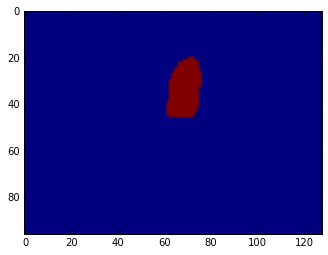

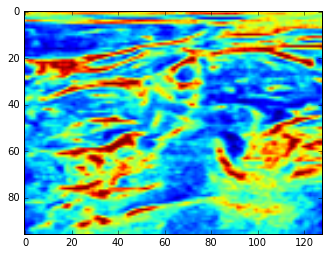

In [72]:
i = 457

plt.imshow(X_pred[i,0,:,:])
plt.show()

print meta_out[i]

print np.sum(X_pred[i,0,:,:])

print np.sum(y[i,0,:,:])
plt.imshow(y[i,0,:,:])
plt.show()

plt.imshow(X[i,0,:,:])
plt.show()

In [25]:
model = models.new_u_net_model('unet_positive_full_weights.h5')
david = model.predict(X)

In [26]:
X_pred = 1.0 * (david > .99)

In [6]:
model = models.u_net_class('class_full_weights.h5')
label_preds1 = model.predict(X)

model = models.make_classifier('simple_fold_0_weights.h5')
label_preds2 = model.predict(X)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:558: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: keras_learning_phase.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  **kwargs)


In [7]:
vgg_out = np.load('/mnt/weights/vgg_preds.npy')
bst = xgb.Booster({'nthread':4})
bst.load_model('xgb.model')
xgb_preds = bst.predict(xgb.DMatrix(vgg_out))

In [9]:
meta_in = np.transpose(np.vstack((label_preds2[:,0], label_preds1[:,0], xgb_preds)))

bst = xgb.Booster({'nthread':4})
bst.load_model('meta.model')
meta_out = bst.predict(xgb.DMatrix(meta_in))

In [15]:
np.sum((label_preds1[:,0] >.5) == (xgb_preds > .5))

4636

In [16]:
np.sum((label_preds2[:,0] >.5) == (xgb_preds > .5))

4510

In [18]:
np.sum((label_preds2[:,0] >.5) == (label_preds1[:,0] >.5))

4797

In [10]:
meta_in = np.transpose(np.vstack((label_preds2[:,0], label_preds1[:,0], xgb_preds)))

In [10]:
param = {'max_depth':3, 'eta':0.1, 'gamma':0, 'silent':0, 'objective':'binary:logistic', 'colsample_bytree':.5,
             'nthread':6, 'min_child_weight':1.4, 'scale_pos_weight':.59/.41}

numround = 50


skf = StratifiedKFold(labels[:,0], n_folds=10, shuffle=True)
meta_preds = np.zeros(labels.shape[0])

for i, (train,test) in enumerate(skf):
    
    dtrain = xgb.DMatrix(meta_in[train, :], label=labels[train, :])
    dtest = xgb.DMatrix(meta_in[test, :], label=labels[test, :])
    
    bst = xgb.train(param, dtrain, numround, [(dtest,'eval'), (dtrain,'train')])
    
    meta_preds[test] = bst.predict(dtest)
    
    print (1.0 * np.sum((meta_preds[test] > .5) == labels[test,0])) / len(test)


[0]	eval-error:0.187611	train-error:0.175542
[1]	eval-error:0.192920	train-error:0.161933
[2]	eval-error:0.192920	train-error:0.160355
[3]	eval-error:0.191150	train-error:0.161933
[4]	eval-error:0.196460	train-error:0.163511
[5]	eval-error:0.189381	train-error:0.161933
[6]	eval-error:0.194690	train-error:0.163905
[7]	eval-error:0.196460	train-error:0.165878
[8]	eval-error:0.198230	train-error:0.166272
[9]	eval-error:0.196460	train-error:0.165680
[10]	eval-error:0.194690	train-error:0.163905
[11]	eval-error:0.196460	train-error:0.164497
[12]	eval-error:0.194690	train-error:0.163708
[13]	eval-error:0.196460	train-error:0.162130
[14]	eval-error:0.194690	train-error:0.161538
[15]	eval-error:0.194690	train-error:0.162130
[16]	eval-error:0.196460	train-error:0.162525
[17]	eval-error:0.194690	train-error:0.161736
[18]	eval-error:0.192920	train-error:0.161933
[19]	eval-error:0.194690	train-error:0.162327
[20]	eval-error:0.194690	train-error:0.162327
[21]	eval-error:0.196460	train-error:0.16213

0.808849557522
0.833628318584

[1]	eval-error:0.171681	train-error:0.166272
[2]	eval-error:0.169912	train-error:0.166469
[3]	eval-error:0.171681	train-error:0.166272
[4]	eval-error:0.166372	train-error:0.167850
[5]	eval-error:0.169912	train-error:0.167653
[6]	eval-error:0.173451	train-error:0.168245
[7]	eval-error:0.173451	train-error:0.169034
[8]	eval-error:0.173451	train-error:0.169822
[9]	eval-error:0.175221	train-error:0.168836
[10]	eval-error:0.173451	train-error:0.168836
[11]	eval-error:0.173451	train-error:0.168639
[12]	eval-error:0.171681	train-error:0.169231
[13]	eval-error:0.166372	train-error:0.167850
[14]	eval-error:0.166372	train-error:0.168245
[15]	eval-error:0.168142	train-error:0.167258
[16]	eval-error:0.168142	train-error:0.167653
[17]	eval-error:0.168142	train-error:0.167850
[18]	eval-error:0.169912	train-error:0.168245
[19]	eval-error:0.168142	train-error:0.168245
[20]	eval-error:0.168142	train-error:0.167258
[21]	eval-error:0.168142	train-error:0.168047
[22]	eval-error:0.166372	train-error:0.1670


0.83865248227
0.831261101243

[0]	eval-error:0.197158	train-error:0.186120
[1]	eval-error:0.174067	train-error:0.166798
[2]	eval-error:0.168739	train-error:0.166798
[3]	eval-error:0.166963	train-error:0.164432
[4]	eval-error:0.172291	train-error:0.166798
[5]	eval-error:0.163410	train-error:0.168573
[6]	eval-error:0.163410	train-error:0.167784
[7]	eval-error:0.165186	train-error:0.168375
[8]	eval-error:0.168739	train-error:0.168573
[9]	eval-error:0.166963	train-error:0.170150
[10]	eval-error:0.166963	train-error:0.167784
[11]	eval-error:0.172291	train-error:0.170938
[12]	eval-error:0.168739	train-error:0.167784
[13]	eval-error:0.165186	train-error:0.168967
[14]	eval-error:0.163410	train-error:0.167784
[15]	eval-error:0.165186	train-error:0.167390
[16]	eval-error:0.163410	train-error:0.167390
[17]	eval-error:0.166963	train-error:0.168573
[18]	eval-error:0.166963	train-error:0.167981
[19]	eval-error:0.165186	train-error:0.168770
[20]	eval-error:0.168739	train-error:0.167390
[21]	eval-error:0.168739	train-error:0.16699


0.83836589698

[1]	eval-error:0.159858	train-error:0.164629
[2]	eval-error:0.161634	train-error:0.164826
[3]	eval-error:0.159858	train-error:0.164432
[4]	eval-error:0.161634	train-error:0.166404
[5]	eval-error:0.163410	train-error:0.168375
[6]	eval-error:0.159858	train-error:0.169164
[7]	eval-error:0.159858	train-error:0.171333
[8]	eval-error:0.163410	train-error:0.171333
[9]	eval-error:0.159858	train-error:0.171136
[10]	eval-error:0.158082	train-error:0.170544
[11]	eval-error:0.159858	train-error:0.170741
[12]	eval-error:0.159858	train-error:0.168375
[13]	eval-error:0.165186	train-error:0.168573
[14]	eval-error:0.165186	train-error:0.167587
[15]	eval-error:0.165186	train-error:0.168178
[16]	eval-error:0.163410	train-error:0.168375
[17]	eval-error:0.163410	train-error:0.168770
[18]	eval-error:0.159858	train-error:0.167981
[19]	eval-error:0.161634	train-error:0.168178
[20]	eval-error:0.163410	train-error:0.168770
[21]	eval-error:0.158082	train-error:0.167784
[22]	eval-error:0.163410	train-error:0.1687


0.836589698046

[1]	eval-error:0.156306	train-error:0.164826
[2]	eval-error:0.158082	train-error:0.165221
[3]	eval-error:0.159858	train-error:0.165024
[4]	eval-error:0.166963	train-error:0.164826
[5]	eval-error:0.174067	train-error:0.166009
[6]	eval-error:0.177620	train-error:0.167784
[7]	eval-error:0.177620	train-error:0.167587
[8]	eval-error:0.181172	train-error:0.169953
[9]	eval-error:0.179396	train-error:0.168375
[10]	eval-error:0.181172	train-error:0.168573
[11]	eval-error:0.177620	train-error:0.167981
[12]	eval-error:0.168739	train-error:0.166601
[13]	eval-error:0.172291	train-error:0.165812
[14]	eval-error:0.165186	train-error:0.166995
[15]	eval-error:0.168739	train-error:0.165812
[16]	eval-error:0.170515	train-error:0.166207
[17]	eval-error:0.174067	train-error:0.166404
[18]	eval-error:0.170515	train-error:0.166601
[19]	eval-error:0.170515	train-error:0.167192
[20]	eval-error:0.172291	train-error:0.166601
[21]	eval-error:0.172291	train-error:0.166798
[22]	eval-error:0.170515	train-error:0.1667


0.808170515098

[2]	eval-error:0.188277	train-error:0.163446
[3]	eval-error:0.188277	train-error:0.160883
[4]	eval-error:0.193606	train-error:0.162461
[5]	eval-error:0.193606	train-error:0.165024
[6]	eval-error:0.193606	train-error:0.165615
[7]	eval-error:0.195382	train-error:0.165812
[8]	eval-error:0.193606	train-error:0.166798
[9]	eval-error:0.193606	train-error:0.166995
[10]	eval-error:0.193606	train-error:0.166207
[11]	eval-error:0.197158	train-error:0.166207
[12]	eval-error:0.193606	train-error:0.166404
[13]	eval-error:0.193606	train-error:0.164826
[14]	eval-error:0.193606	train-error:0.163644
[15]	eval-error:0.191829	train-error:0.163446
[16]	eval-error:0.193606	train-error:0.164235
[17]	eval-error:0.193606	train-error:0.164826
[18]	eval-error:0.193606	train-error:0.164038
[19]	eval-error:0.193606	train-error:0.164826
[20]	eval-error:0.193606	train-error:0.164432
[21]	eval-error:0.193606	train-error:0.164432
[22]	eval-error:0.193606	train-error:0.164038
[23]	eval-error:0.193606	train-error:0.164


0.822380106572

[1]	eval-error:0.174067	train-error:0.164038
[2]	eval-error:0.175844	train-error:0.162263
[3]	eval-error:0.174067	train-error:0.164038
[4]	eval-error:0.172291	train-error:0.165221
[5]	eval-error:0.179396	train-error:0.166404
[6]	eval-error:0.182948	train-error:0.167784
[7]	eval-error:0.182948	train-error:0.169558
[8]	eval-error:0.181172	train-error:0.168573
[9]	eval-error:0.188277	train-error:0.167981
[10]	eval-error:0.184725	train-error:0.168178
[11]	eval-error:0.186501	train-error:0.168573
[12]	eval-error:0.188277	train-error:0.168770
[13]	eval-error:0.175844	train-error:0.167784
[14]	eval-error:0.175844	train-error:0.166601
[15]	eval-error:0.175844	train-error:0.166995
[16]	eval-error:0.174067	train-error:0.166798
[17]	eval-error:0.175844	train-error:0.166207
[18]	eval-error:0.179396	train-error:0.165812
[19]	eval-error:0.179396	train-error:0.166404
[20]	eval-error:0.181172	train-error:0.166207
[21]	eval-error:0.181172	train-error:0.166601
[22]	eval-error:0.179396	train-error:0.1664


0.847246891652

[1]	eval-error:0.145648	train-error:0.167192
[2]	eval-error:0.152753	train-error:0.175276
[3]	eval-error:0.145648	train-error:0.166995
[4]	eval-error:0.147425	train-error:0.168375
[5]	eval-error:0.152753	train-error:0.169558
[6]	eval-error:0.149201	train-error:0.169164
[7]	eval-error:0.150977	train-error:0.170544
[8]	eval-error:0.150977	train-error:0.172121
[9]	eval-error:0.149201	train-error:0.172319
[10]	eval-error:0.147425	train-error:0.171727
[11]	eval-error:0.152753	train-error:0.171924
[12]	eval-error:0.149201	train-error:0.170150
[13]	eval-error:0.150977	train-error:0.170544
[14]	eval-error:0.150977	train-error:0.169756
[15]	eval-error:0.150977	train-error:0.169953
[16]	eval-error:0.152753	train-error:0.170544
[17]	eval-error:0.152753	train-error:0.169558
[18]	eval-error:0.150977	train-error:0.169164
[19]	eval-error:0.152753	train-error:0.170150
[20]	eval-error:0.152753	train-error:0.169756
[21]	eval-error:0.150977	train-error:0.169756
[22]	eval-error:0.152753	train-error:0.1695


0.845470692718


[1]	eval-error:0.158082	train-error:0.164629
[2]	eval-error:0.161634	train-error:0.173304
[3]	eval-error:0.158082	train-error:0.164826
[4]	eval-error:0.152753	train-error:0.169164
[5]	eval-error:0.156306	train-error:0.169361
[6]	eval-error:0.158082	train-error:0.170938
[7]	eval-error:0.158082	train-error:0.171924
[8]	eval-error:0.161634	train-error:0.172121
[9]	eval-error:0.159858	train-error:0.171333
[10]	eval-error:0.158082	train-error:0.169953
[11]	eval-error:0.158082	train-error:0.171530
[12]	eval-error:0.154529	train-error:0.169953
[13]	eval-error:0.152753	train-error:0.168573
[14]	eval-error:0.154529	train-error:0.168573
[15]	eval-error:0.152753	train-error:0.167981
[16]	eval-error:0.156306	train-error:0.167587
[17]	eval-error:0.154529	train-error:0.168573
[18]	eval-error:0.154529	train-error:0.168967
[19]	eval-error:0.154529	train-error:0.169164
[20]	eval-error:0.154529	train-error:0.169164
[21]	eval-error:0.154529	train-error:0.168770
[22]	eval-error:0.152753	train-error:0.1679

In [11]:
print (1.0 * np.sum((meta_preds > .5) == labels[:,0])) / len(meta_preds)

0.831055900621


In [ ]:
dtrain = xgb.DMatrix(meta_in, label=labels)
bst = xgb.train(param, dtrain, numround)
bst.save_model('meta.model')

In [22]:
oos_class_preds = label_preds1

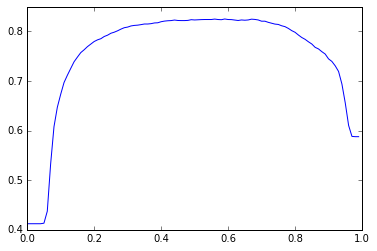

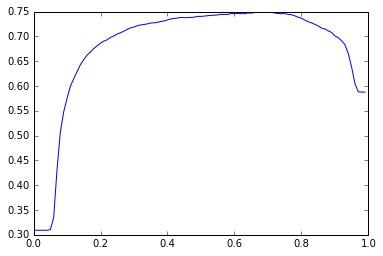

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline

x_range = np.arange(0,1,.01)

y_range = np.zeros(len(x_range))
dice_guess = np.zeros(len(x_range))

for i, x in enumerate(x_range):
    y_range[i] = (1.0 * np.sum(labels == 1.0 * (oos_class_preds > x))) / len(y)
    
    correct_pos = np.sum(labels + 1.0 * (oos_class_preds > x) == 2)
    correct_neg = (1.0 * np.sum(labels == 1.0 * (oos_class_preds > x))) - correct_pos
    dice_guess[i] = (correct_neg + .75 * correct_pos) / len(y)
    

plt.plot(x_range, y_range)
plt.show()

plt.plot(x_range, dice_guess)
plt.show()

[2814, 956, 1865]
10
[2814, 956, 1865]
20
[2814, 956, 1865]
30
[2814, 956, 1865]
40
[2814, 956, 1865]
50
[2814, 956, 1865]
60
[2814, 956, 1865]
70
[2814, 956, 1865]
80
[2814, 956, 1865]
90
[2814, 956, 1865]
100
[2814, 956, 1865]
110
[2814, 956, 1865]
120
[2814, 956, 1865]
130
[2814, 956, 1865]
140
[2814, 956, 1865]
150
[2814, 956, 1865]
160
[2815, 955, 1865]
170
[2815, 955, 1865]
180
[2815, 955, 1865]
190
[2815, 955, 1865]
200
[2815, 955, 1865]
210
[2815, 955, 1865]
220
[2815, 955, 1865]
230
[2815, 955, 1865]
240
[2815, 955, 1865]
250
[2815, 955, 1865]
260
[2815, 955, 1865]
270
[2818, 952, 1865]
280
[2819, 953, 1863]
290
[2820, 952, 1863]
300
[2822, 959, 1854]
310
[2825, 961, 1849]
320
[2830, 968, 1837]
330
[2842, 976, 1817]
340
[2851, 1000, 1784]
350
[2863, 1032, 1740]
360
[2878, 1062, 1695]
370
[2893, 1111, 1631]
380
[2904, 1154, 1577]
390


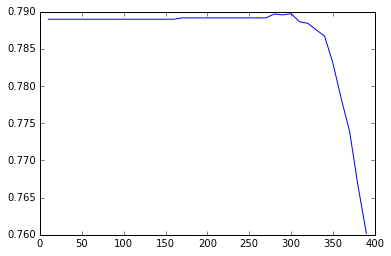

In [29]:
#x_range = np.arange(.2,.7,.01)
x_range = np.arange(10,400,10)
y_range = np.zeros(len(x_range))

for i, x in enumerate(x_range):
    X_pred_temp = np.copy(X_pred)
    
    #pred_labels = 1.0 * ((label_preds2[:,0] > x) and  (label_preds1[:,0] > x) and (xgb_preds > x))
    
    for j in range(X_pred.shape[0]):
        if np.sum(X_pred_temp[j, 0, :, :]) < x or meta_preds[j] < .55:
            X_pred_temp[j, 0, :, :] = np.zeros((96, 128))
    
    y_range[i] = get_dice(X_pred_temp, y)
    print x

plt.plot(x_range, y_range)
plt.show()

In [13]:
def get_dice(X, y):
        
    counts = [0,0,0]
    dice_list = list()
    for i in range(X.shape[0]):
        pred = X[i, 0, :, :]
        mask = y[i, 0, :,]

        total = np.add(pred, mask)
        correct = np.sum(total > 1.5)

        if np.sum(pred) + np.sum(mask) == 0:
            result_dice = 1.0
            counts[0] += 1
        else:
            result_dice = (2.0 * correct) / (np.sum(pred) + np.sum(mask))
            if correct == 0:
                counts[1] += 1
            else:
                counts[2] += 1

        dice_list.append(result_dice)
    
    print counts
    return np.mean(dice_list)

In [30]:
get_dice(X_pred, y)

[142, 3177, 2316]


0.3834873501788546

In [26]:
pred_labels = np.zeros(labels.shape[0])
for i in range(len(labels)):
    if np.sum(oos_preds[i, 0, :, :] > .9) > 10:
        pred_labels[i] = 1

In [27]:
np.sum((1.0 * (pred_labels == labels))) / len(labels)

0.80354924578527065

In [103]:
class_preds = 1.0 * (class_oos_preds > .65)

In [28]:
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(len(labels)):
    if pred_labels[i] == 0 and labels[i] == 0:
        tn += 1
    if pred_labels[i] == 0 and labels[i] == 1:
        fn += 1
    if pred_labels[i] == 1 and labels[i] == 1:
        tp += 1
    if pred_labels[i] == 1 and labels[i] == 0:
        fp += 1      

In [6]:
(1.0 * tp) / (tp + fn)

NameError: name 'tp' is not defined

In [30]:
(1.0 * tn) / (tn + fp)

0.8800413650465356

In [35]:
tn + fn

2901

In [105]:
(tn + .6 * tp) / (tp + fp + tn + fn)

0.6773025732031943

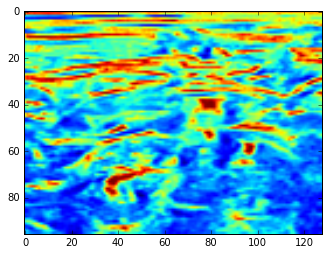

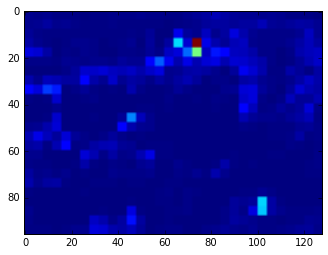

6.99547745171e-05
0.0180627405254


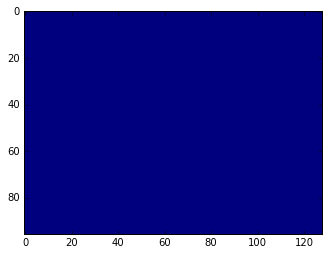

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(X[130, 0, :, :])
plt.show()

plt.imshow(oos_preds[130, 0, :, :])
plt.show()
print np.amax(oos_preds[130, 0, :, :])
print np.sum(oos_preds[130, 0, :, :])

plt.imshow(y[130, 0, :, :])
plt.show()

In [10]:
im_generator = ImageDataGenerator(rotation_range=10, width_shift_range = .1,
                               height_shift_range= .06, shear_range = .25)
train_generator = im_generator.flow(X,labels, shuffle=True, batch_size=32)


model = None # Clearing the NN.
model = models.make_classifier()

Checkpoint = ModelCheckpoint('simple_full_weights.h5')
model.fit_generator(train_generator, 5600, 20,
                      callbacks = [Checkpoint],
                       class_weight = {0:.41, 1:.59})

Epoch 1/20
5600/5600 [==============================] - 24s - loss: 0.3256 - acc: 0.5736    
Epoch 2/20
5603/5600 [==============================] - 24s - loss: 0.3048 - acc: 0.6509    
Epoch 3/20
5603/5600 [==============================] - 24s - loss: 0.2843 - acc: 0.6989    
Epoch 4/20
5603/5600 [==============================] - 24s - loss: 0.2672 - acc: 0.7339    
Epoch 5/20
5603/5600 [==============================] - 24s - loss: 0.2602 - acc: 0.7419    
Epoch 6/20
5603/5600 [==============================] - 24s - loss: 0.2478 - acc: 0.7582    
Epoch 7/20
5603/5600 [==============================] - 24s - loss: 0.2446 - acc: 0.7626    
Epoch 8/20
5603/5600 [==============================] - 24s - loss: 0.2395 - acc: 0.7780    
Epoch 9/20
5603/5600 [==============================] - 24s - loss: 0.2341 - acc: 0.7710    
Epoch 10/20
5603/5600 [==============================] - 24s - loss: 0.2291 - acc: 0.7789    
Epoch 11/20
5603/5600 [==============================] - 24s - loss: 

In [69]:
n_folds = 5

skf = StratifiedKFold(labels[:,0], n_folds=n_folds, shuffle=True)

ES = EarlyStopping(monitor = 'val_loss', patience = 2, mode = 'min')

class_oos_preds = np.zeros(labels.shape)

#train with Cross validation
for i, (train, test) in enumerate(skf):
    print "Running Fold", i+1, "/", n_folds

    model = None # Clearing the NN.
    model = models.make_classifier()

    train_generator = im_generator.flow(X[train, :, :, :],labels[train], shuffle=True, batch_size=32)

    
    Checkpoint = ModelCheckpoint('simple_full_weights.h5', save_best_only=True)
    model.fit_generator(train_generator, 5600, 20,
                      callbacks = [Checkpoint],
                      validation_data = (X[test, :, :, :], labels[test]),
                       class_weight = {0:.41, 1:.59})


    model = models.make_classifier('fold_' + str(i) + '_weights.h5')
    class_oos_preds[test] = model.predict(X[test, :, :, :])

Running Fold 1 / 5
Epoch 1/40
4507/4500 [==============================] - 20s - loss: 0.3244 - acc: 0.5775 - val_loss: 0.5700 - val_acc: 0.7057
Epoch 2/40
4507/4500 [==============================] - 20s - loss: 0.2955 - acc: 0.6761 - val_loss: 0.5588 - val_acc: 0.7394
Epoch 3/40
4507/4500 [==============================] - 20s - loss: 0.2799 - acc: 0.7078 - val_loss: 0.5351 - val_acc: 0.7447
Epoch 4/40
4507/4500 [==============================] - 20s - loss: 0.2700 - acc: 0.7264 - val_loss: 0.5350 - val_acc: 0.7394
Epoch 5/40
4507/4500 [==============================] - 20s - loss: 0.2654 - acc: 0.7342 - val_loss: 0.5198 - val_acc: 0.7535
Epoch 6/40
4507/4500 [==============================] - 20s - loss: 0.2558 - acc: 0.7355 - val_loss: 0.5038 - val_acc: 0.7651
Epoch 7/40
4507/4500 [==============================] - 20s - loss: 0.2493 - acc: 0.7546 - val_loss: 0.5013 - val_acc: 0.7713
Epoch 8/40
4507/4500 [==============================] - 20s - loss: 0.2461 - acc: 0.7570 - val_loss

KeyboardInterrupt: 

In [52]:
n_folds = 5

skf = StratifiedKFold(labels, n_folds=n_folds, shuffle=True)

ES = EarlyStopping(monitor = 'val_loss', patience = 2, mode = 'min')

oos_preds = np.zeros(y.shape)
    
for i, (train, test) in enumerate(skf):
    print "Running Fold", i+1, "/", n_folds

    model = None # Clearing the NN.
    model = models.u_net_model()
    
    Checkpoint = ModelCheckpoint('unet_fold_' + str(i) + '_weights.h5', save_best_only=True)
    model.fit_generator(generator(X[train, :, :, :],y[train, :, :, :]), 4500, 20,
                      callbacks = [Checkpoint],
                      validation_data = (X[test, :, :, :], y[test, :, :, :]))
    
    model = None # Clearing the NN.
    model = models.double_input_model(u_weights = 'unet_fold_' + str(i) + '_weights.h5')
    
    train_datagen = ImageDataGenerator()
    train_generator = train_datagen.flow(X[train, :, :, :],y[train, :, :, :], shuffle=True, batch_size=32)
    
    Checkpoint = ModelCheckpoint('double_fold_' + str(i) + '_weights.h5', save_best_only=True)
    model.fit_generator(train_generator, 4500, 10,
                      callbacks = [Checkpoint],
                      validation_data = (X[test, :, :, :], y[test, :, :, :]))


    model = models.double_input_model('double_fold_' + str(i) + '_weights.h5')
    oos_preds[test, :, :, :] = model.predict(X[test, :, :, :])

Running Fold 1 / 5
Epoch 1/20
4512/4500 [==============================] - 280s - loss: -0.3196 - dice_coef: 0.3196 - val_loss: -0.5037 - val_dice_coef: 0.5037
Epoch 2/20
4512/4500 [==============================] - 279s - loss: -0.5441 - dice_coef: 0.5441 - val_loss: -0.5613 - val_dice_coef: 0.5613
Epoch 3/20
4512/4500 [==============================] - 278s - loss: -0.5821 - dice_coef: 0.5821 - val_loss: -0.5858 - val_dice_coef: 0.5858
Epoch 4/20
4512/4500 [==============================] - 277s - loss: -0.5931 - dice_coef: 0.5931 - val_loss: -0.5832 - val_dice_coef: 0.5832
Epoch 5/20
4512/4500 [==============================] - 278s - loss: -0.6082 - dice_coef: 0.6082 - val_loss: -0.5915 - val_dice_coef: 0.5915
Epoch 6/20
4512/4500 [==============================] - 278s - loss: -0.6334 - dice_coef: 0.6334 - val_loss: -0.5897 - val_dice_coef: 0.5897
Epoch 7/20
4512/4500 [==============================] - 278s - loss: -0.6230 - dice_coef: 0.6230 - val_loss: -0.6095 - val_dice_coef: 0

KeyboardInterrupt: 

In [49]:
smoother = models.smoother()

Checkpoint = ModelCheckpoint('smoother_weights.h5', save_best_only=True)
smoother.fit(oos_preds, y, 32, 20, callbacks = [Checkpoint],
                      validation_split = .1)

Train on 5071 samples, validate on 564 samples
Epoch 1/20
5071/5071 [==============================] - 13s - loss: -0.5689 - dice_coef: 0.5689 - val_loss: -0.6482 - val_dice_coef: 0.6482
Epoch 2/20
5071/5071 [==============================] - 13s - loss: -0.6553 - dice_coef: 0.6553 - val_loss: -0.6508 - val_dice_coef: 0.6508
Epoch 3/20
5071/5071 [==============================] - 13s - loss: -0.6560 - dice_coef: 0.6560 - val_loss: -0.6503 - val_dice_coef: 0.6503
Epoch 4/20
5071/5071 [==============================] - 13s - loss: -0.6569 - dice_coef: 0.6569 - val_loss: -0.6505 - val_dice_coef: 0.6505
Epoch 5/20
5071/5071 [==============================] - 13s - loss: -0.6541 - dice_coef: 0.6541 - val_loss: -0.6481 - val_dice_coef: 0.6481
Epoch 6/20
5071/5071 [==============================] - 13s - loss: -0.6532 - dice_coef: 0.6532 - val_loss: -0.6503 - val_dice_coef: 0.6503
Epoch 7/20
3328/5071 [==================>...........] - ETA: 4s - loss: -0.6551 - dice_coef: 0.6551

KeyboardInterrupt: 

In [7]:
vgg_out = np.load('/mnt/weights/vgg_preds.npy')

In [8]:
param = {'max_depth':4, 'eta':0.15, 'gamma':0, 'silent':0, 'objective':'binary:logistic', 'colsample_bytree':.5,
             'nthread':6, 'min_child_weight':1.4, 'scale_pos_weight':.59/.41}

numround = 50


skf = StratifiedKFold(labels[:,0], n_folds=5, shuffle=True)
xgb_preds = np.zeros(labels.shape[0])

for i, (train,test) in enumerate(skf):
    
    dtrain = xgb.DMatrix(vgg_out[train, :], label=labels[train, :])
    dtest = xgb.DMatrix(vgg_out[test, :], label=labels[test, :])
    
    bst = xgb.train(param, dtrain, numround, [(dtest,'eval'), (dtrain,'train')])
    
    xgb_preds[test] = bst.predict(dtest)
    
    print (1.0 * np.sum((xgb_preds[test] > .5) == labels[test,0])) / len(test)

[0]	eval-error:0.345745	train-error:0.304637
[1]	eval-error:0.335106	train-error:0.270246
[2]	eval-error:0.313830	train-error:0.248946
[3]	eval-error:0.311170	train-error:0.232749
[4]	eval-error:0.296986	train-error:0.221211
[5]	eval-error:0.293440	train-error:0.211005
[6]	eval-error:0.302305	train-error:0.209230
[7]	eval-error:0.296986	train-error:0.194364
[8]	eval-error:0.284574	train-error:0.192811
[9]	eval-error:0.283688	train-error:0.188152
[10]	eval-error:0.276596	train-error:0.179499
[11]	eval-error:0.283688	train-error:0.173952
[12]	eval-error:0.281028	train-error:0.166408
[13]	eval-error:0.268617	train-error:0.161970
[14]	eval-error:0.266844	train-error:0.159530
[15]	eval-error:0.270390	train-error:0.155092
[16]	eval-error:0.265957	train-error:0.150876
[17]	eval-error:0.266844	train-error:0.144664
[18]	eval-error:0.261525	train-error:0.138451
[19]	eval-error:0.260638	train-error:0.133126
[20]	eval-error:0.258865	train-error:0.122920
[21]	eval-error:0.252660	train-error:0.12358

0.765070921986
0.757978723404

[0]	eval-error:0.352263	train-error:0.316992
[1]	eval-error:0.331854	train-error:0.283496
[2]	eval-error:0.323869	train-error:0.254215
[3]	eval-error:0.322094	train-error:0.246007
[4]	eval-error:0.321207	train-error:0.225155
[5]	eval-error:0.322981	train-error:0.220053
[6]	eval-error:0.310559	train-error:0.209405
[7]	eval-error:0.299024	train-error:0.201863
[8]	eval-error:0.300799	train-error:0.193656
[9]	eval-error:0.305235	train-error:0.186779
[10]	eval-error:0.296362	train-error:0.178350
[11]	eval-error:0.302573	train-error:0.172360
[12]	eval-error:0.292813	train-error:0.164374
[13]	eval-error:0.297249	train-error:0.157720
[14]	eval-error:0.294587	train-error:0.154392
[15]	eval-error:0.289264	train-error:0.144188
[16]	eval-error:0.282165	train-error:0.139530
[17]	eval-error:0.281278	train-error:0.139752
[18]	eval-error:0.287489	train-error:0.136646
[19]	eval-error:0.283052	train-error:0.132875
[20]	eval-error:0.282165	train-error:0.127551
[21]	eval-error:0.273292	train-error:0.12533


0.738243123336

[0]	eval-error:0.334814	train-error:0.284320
[1]	eval-error:0.333925	train-error:0.263473
[2]	eval-error:0.314387	train-error:0.247505
[3]	eval-error:0.303730	train-error:0.231315
[4]	eval-error:0.290409	train-error:0.218896
[5]	eval-error:0.301066	train-error:0.209581
[6]	eval-error:0.281528	train-error:0.198270
[7]	eval-error:0.292185	train-error:0.196496
[8]	eval-error:0.291297	train-error:0.188290
[9]	eval-error:0.287744	train-error:0.182080
[10]	eval-error:0.287744	train-error:0.174096
[11]	eval-error:0.280639	train-error:0.166778
[12]	eval-error:0.278863	train-error:0.165003
[13]	eval-error:0.272647	train-error:0.158350
[14]	eval-error:0.277975	train-error:0.153471
[15]	eval-error:0.262877	train-error:0.150588
[16]	eval-error:0.265542	train-error:0.144821
[17]	eval-error:0.269982	train-error:0.139277
[18]	eval-error:0.269094	train-error:0.137059
[19]	eval-error:0.257549	train-error:0.134398
[20]	eval-error:0.259325	train-error:0.129741
[21]	eval-error:0.259325	train-error:0.12863


0.740674955595

[0]	eval-error:0.351687	train-error:0.285651
[1]	eval-error:0.339254	train-error:0.263029
[2]	eval-error:0.333037	train-error:0.239965
[3]	eval-error:0.315275	train-error:0.229097
[4]	eval-error:0.312611	train-error:0.215569
[5]	eval-error:0.301954	train-error:0.210246
[6]	eval-error:0.296625	train-error:0.200266
[7]	eval-error:0.297513	train-error:0.196496
[8]	eval-error:0.299290	train-error:0.185851
[9]	eval-error:0.294849	train-error:0.180528
[10]	eval-error:0.297513	train-error:0.174540
[11]	eval-error:0.290409	train-error:0.169439
[12]	eval-error:0.284192	train-error:0.163673
[13]	eval-error:0.285968	train-error:0.157241
[14]	eval-error:0.272647	train-error:0.151253
[15]	eval-error:0.272647	train-error:0.146596
[16]	eval-error:0.275311	train-error:0.142382
[17]	eval-error:0.269094	train-error:0.134176
[18]	eval-error:0.264654	train-error:0.131293
[19]	eval-error:0.265542	train-error:0.126857
[20]	eval-error:0.266430	train-error:0.123752
[21]	eval-error:0.263766	train-error:0.12175


0.746003552398


In [64]:
(1.0 * np.sum((xgb_preds > .5) == labels[:,0])) / len(xgb_preds)

0.7563442768411712

In [65]:
dtrain = xgb.DMatrix(vgg_out, label=labels)
bst = xgb.train(param, dtrain, numround)
bst.save_model('xgb.model')